In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader, random_split



import torch.nn.functional as F
from torchvision.transforms import functional as Func

import tifffile as tiff
import os
import time

from torchvision.transforms import RandomResizedCrop


Huge change from previous implementations since we are using target day10 images,we need to give same transform to day10 image as same as day7. hence we removed transform.compose instead we used from torchvision.transforms import functional as Func

In [6]:
class ImageDataset(Dataset):
    def __init__(self, day7_dir, day10_dir):
        self.day7_files = {os.path.basename(file): os.path.join(day7_dir, file) for file in os.listdir(day7_dir) if file.endswith('.tiff')}
        self.day10_files = {os.path.basename(file): os.path.join(day10_dir, file) for file in os.listdir(day10_dir) if file.endswith('.tiff')}
      
        # Ensure all day7 files have a corresponding day10 file
        self.common_files = list(self.day7_files.keys())
        assert set(self.common_files) <= set(self.day10_files.keys()), "Mismatch between day7 and day10 filenames."

    def __len__(self):
        return len(self.common_files)

    def __getitem__(self, idx):
        filename = self.common_files[idx]
        day7_img_path = self.day7_files[filename]
        day10_img_path = self.day10_files[filename]

        # Load the images
        day7_img = tiff.imread(day7_img_path)
        day10_img = tiff.imread(day10_img_path)

        # Ensure the images have 3 layers (channels)
        if day7_img.shape[0] != 3:
            raise ValueError(f"Day7 image at {day7_img_path} does not have exactly 3 layers. Found shape: {day7_img.shape}.")
        if day10_img.shape[0] != 3:
            raise ValueError(f"Day10 image at {day10_img_path} does not have exactly 3 layers. Found shape: {day10_img.shape}.")

        # Normalize and convert both images
        day7_img = day7_img.astype(np.float32) / 65535.0
        day10_img = day10_img.astype(np.float32) / 65535.0

        # Convert to tensors
        day7_img = torch.tensor(day7_img, dtype=torch.float32)
        day10_img = torch.tensor(day10_img, dtype=torch.float32)

        # Create augmented versions
        day7_img_aug = day7_img.clone()
        day10_img_aug = day10_img.clone()

        # Apply RandomHorizontalFlip
        if torch.rand(1) < 0.5:
            day7_img_aug = Func.hflip(day7_img_aug)
            day10_img_aug = Func.hflip(day10_img_aug)

        # Apply RandomVerticalFlip
        if torch.rand(1) < 0.5:
            day7_img_aug = Func.vflip(day7_img_aug)
            day10_img_aug = Func.vflip(day10_img_aug)

        # Apply RandomRotation
        angle = torch.randint(-10, 10, (1,)).item()  # Generate a random angle
        day7_img_aug = Func.rotate(day7_img_aug, angle)
        day10_img_aug = Func.rotate(day10_img_aug, angle)

        # Apply RandomResizedCrop
        crop_transform = RandomResizedCrop(size=256)
        i, j, h, w = crop_transform.get_params(day7_img, scale=(0.08, 1.0), ratio=(3 / 4, 4 / 3))
        day7_img_aug = Func.resized_crop(day7_img_aug, i, j, h, w, size=(256, 256))
        day10_img_aug = Func.resized_crop(day10_img_aug, i, j, h, w, size=(256, 256))

        return day7_img_aug, day10_img_aug, day7_img, day10_img,day7_img_path,day10_img_path

    
# Specify paths for both day7 and day10 folders
day7_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\day7'
day10_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\day10'

# Create the dataset
dataset = ImageDataset(day7_dir=day7_dir, day10_dir=day10_dir)

In [3]:
for i, (day7_img, day10_img) in enumerate(dataset):
    print(f"Day 7 Image Shape: {day7_img.shape}, Day 10 Image Shape: {day10_img.shape}")
    if i == 1:  # Check just a couple of samples
        break


ValueError: too many values to unpack (expected 2)

In [7]:
# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

batch_size = 16
# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [8]:
# Calculate the total number of images in the training dataset
total_images_in_train = len(train_loader.dataset)
print(f"Total number of images: {total_images_in_train}")

Total number of images: 104


In [9]:
# Calculate the total number of images in the training dataset
total_images_in_val = len(val_loader.dataset)
print(f"Total number of images: {total_images_in_val}")

Total number of images: 26


In [10]:
# Print the shape of both pairs and total number of images in one epoch
for i, (input_image, target_image) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Input image (day7): {input_image.shape}")
    print(f"  Target image (day10): {target_image.shape}")
    break

Batch 0:
  Input image (day7): torch.Size([16, 3, 256, 256])
  Target image (day10): torch.Size([16, 3, 256, 256])


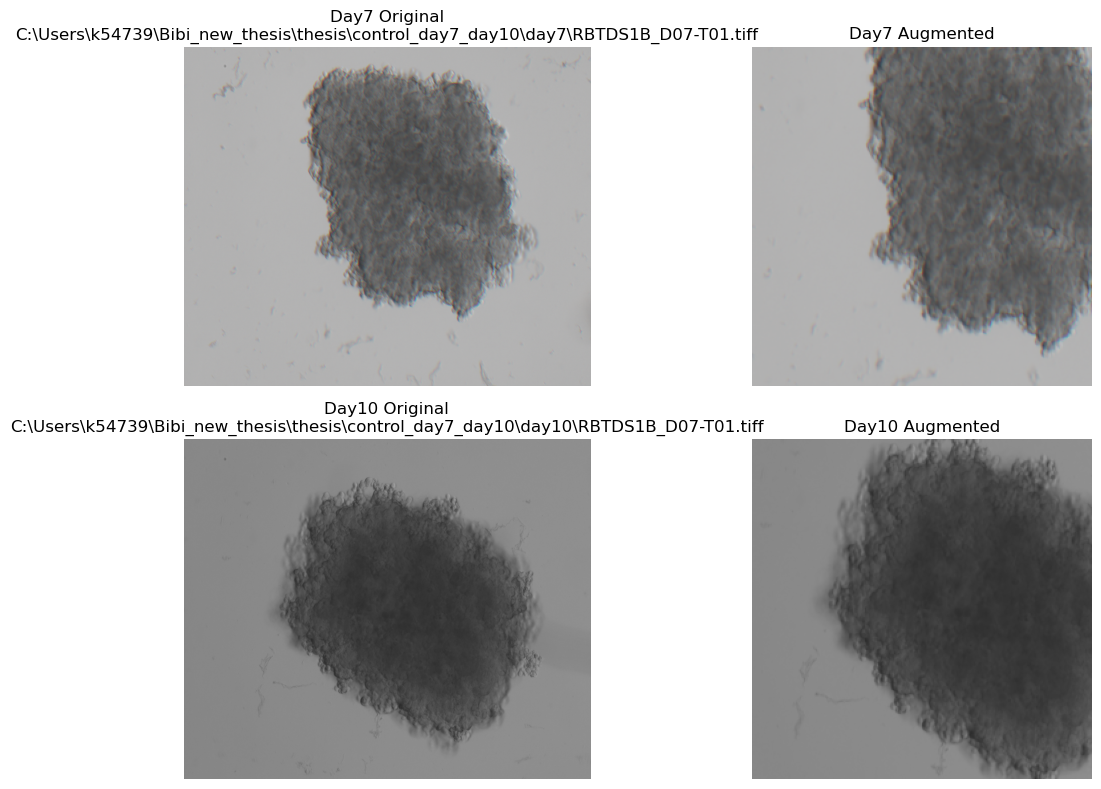

In [7]:
# Retrieve one dataset sample
day7_img_aug, day10_img_aug, day7_img, day10_img, day7_img_path, day10_img_path = dataset[0]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()
day7_img_aug_np = day7_img_aug.permute(1, 2, 0).numpy()
day10_img_aug_np = day10_img_aug.permute(1, 2, 0).numpy()

# Display images with paths
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
plt.title(f"Day7 Original\n{day7_img_path}")
plt.axis("off")

# Day7 Augmented
plt.subplot(2, 2, 2)
plt.imshow(day7_img_aug_np)
plt.title("Day7 Augmented")
plt.axis("off")

# Day10 Original
plt.subplot(2, 2, 3)
plt.imshow(day10_img_np)
plt.title(f"Day10 Original\n{day10_img_path}")
plt.axis("off")

# Day10 Augmented
plt.subplot(2, 2, 4)
plt.imshow(day10_img_aug_np)
plt.title("Day10 Augmented")
plt.axis("off")

plt.tight_layout()
plt.show()


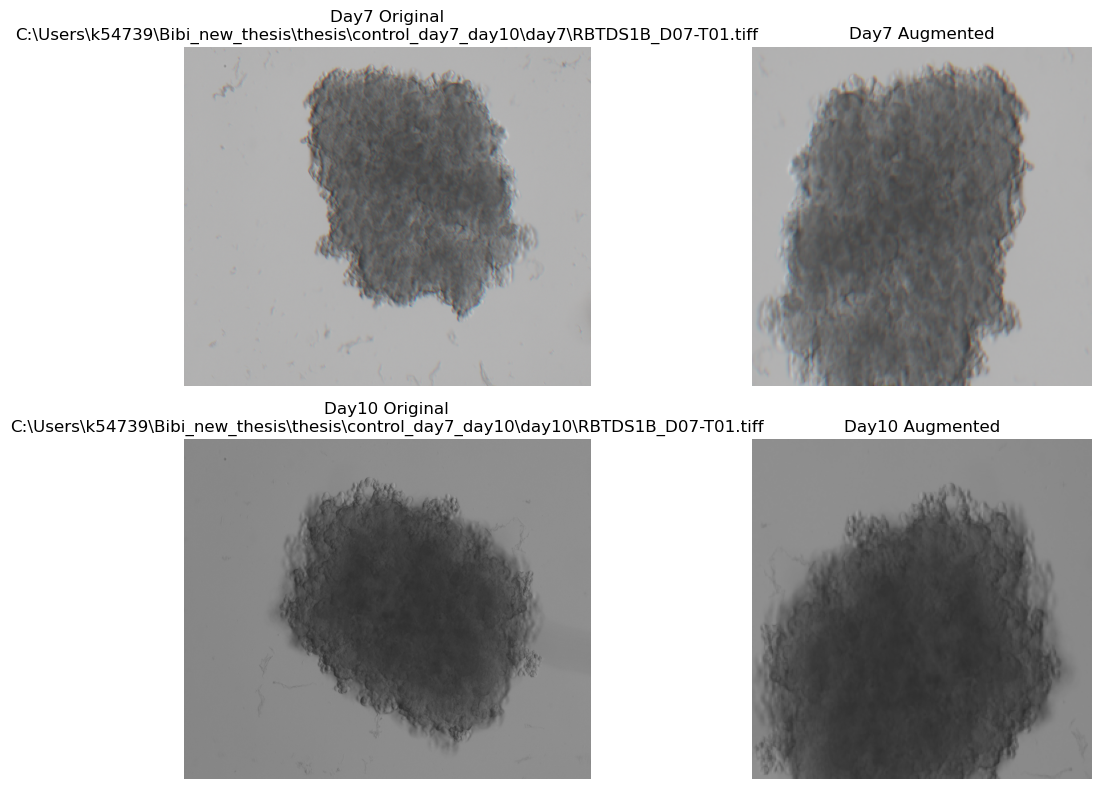

In [8]:
# Retrieve one dataset sample
day7_img_aug, day10_img_aug, day7_img, day10_img, day7_img_path, day10_img_path = dataset[0]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()
day7_img_aug_np = day7_img_aug.permute(1, 2, 0).numpy()
day10_img_aug_np = day10_img_aug.permute(1, 2, 0).numpy()

# Display images with paths
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
plt.title(f"Day7 Original\n{day7_img_path}")
plt.axis("off")

# Day7 Augmented
plt.subplot(2, 2, 2)
plt.imshow(day7_img_aug_np)
plt.title("Day7 Augmented")
plt.axis("off")

# Day10 Original
plt.subplot(2, 2, 3)
plt.imshow(day10_img_np)
plt.title(f"Day10 Original\n{day10_img_path}")
plt.axis("off")

# Day10 Augmented
plt.subplot(2, 2, 4)
plt.imshow(day10_img_aug_np)
plt.title("Day10 Augmented")
plt.axis("off")

plt.tight_layout()
plt.show()


In [11]:
class Autoencod_fituning(nn.Module):
    def __init__(self):
        super(Autoencod_fituning, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding='same'),  # Input: (3, 96, 96) Output: (64, 96, 96)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        # Output: (64, 48, 48)
            
            nn.Conv2d(16, 32, kernel_size=3, padding='same'), # Output: (32, 48, 48)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        # Output: (32, 24, 24)
            
            nn.Conv2d(32, 64, kernel_size=3, padding='same'), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0)         # Output: (16, 12, 12)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding='same'), # Output: (32, 12, 12)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (32, 24, 24)
    
            nn.Conv2d(32, 16, kernel_size=3, padding='same'), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (16, 48, 48)
    
            nn.Conv2d(16, 3, kernel_size=3, padding='same'),  # Output: (3, 48, 48)
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (3, 96, 96)
            nn.Sigmoid()                                      # Ensures output values are in [0, 1] range
        )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x


In [12]:
modi = Autoencod_fituning()
criterion = nn.MSELoss()
optimizer = optim.Adam(modi.parameters(), lr=0.001)

In [13]:
def train_and_validate(modi, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        modi.train()
        train_loss = 0
        for input_images, target_images in train_loader:
            optimizer.zero_grad()
            outputs = modi(input_images)
            loss = criterion(outputs, target_images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        modi.eval()
        val_loss = 0
        with torch.no_grad():
            for input_images, target_images in val_loader:
                outputs = modi(input_images)
                loss = criterion(outputs, target_images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses





In [14]:
train_losses, val_losses = train_and_validate(modi, train_loader, val_loader, optimizer, criterion, num_epochs=1)

Epoch [1/1], Train Loss: 0.0424, Validation Loss: 0.0419, Time: 21.49 seconds


In [15]:
train_losses, val_losses = train_and_validate(modi, train_loader, val_loader, optimizer, criterion, num_epochs=10)

Epoch [1/10], Train Loss: 0.0389, Validation Loss: 0.0273, Time: 21.56 seconds
Epoch [2/10], Train Loss: 0.0290, Validation Loss: 0.0251, Time: 22.33 seconds
Epoch [3/10], Train Loss: 0.0256, Validation Loss: 0.0231, Time: 22.50 seconds
Epoch [4/10], Train Loss: 0.0238, Validation Loss: 0.0233, Time: 22.85 seconds
Epoch [5/10], Train Loss: 0.0266, Validation Loss: 0.0216, Time: 22.47 seconds
Epoch [6/10], Train Loss: 0.0240, Validation Loss: 0.0204, Time: 23.15 seconds
Epoch [7/10], Train Loss: 0.0233, Validation Loss: 0.0200, Time: 23.13 seconds
Epoch [8/10], Train Loss: 0.0239, Validation Loss: 0.0192, Time: 22.91 seconds
Epoch [9/10], Train Loss: 0.0243, Validation Loss: 0.0217, Time: 21.73 seconds
Epoch [10/10], Train Loss: 0.0246, Validation Loss: 0.0214, Time: 21.83 seconds


In [16]:
train_losses, val_losses = train_and_validate(modi, train_loader, val_loader, optimizer, criterion, num_epochs=100)

Epoch [1/100], Train Loss: 0.0222, Validation Loss: 0.0182, Time: 22.77 seconds
Epoch [2/100], Train Loss: 0.0233, Validation Loss: 0.0247, Time: 22.28 seconds
Epoch [3/100], Train Loss: 0.0237, Validation Loss: 0.0205, Time: 21.37 seconds
Epoch [4/100], Train Loss: 0.0232, Validation Loss: 0.0218, Time: 21.61 seconds
Epoch [5/100], Train Loss: 0.0226, Validation Loss: 0.0193, Time: 21.93 seconds
Epoch [6/100], Train Loss: 0.0229, Validation Loss: 0.0205, Time: 22.19 seconds
Epoch [7/100], Train Loss: 0.0239, Validation Loss: 0.0222, Time: 31.80 seconds
Epoch [8/100], Train Loss: 0.0230, Validation Loss: 0.0186, Time: 40.98 seconds
Epoch [9/100], Train Loss: 0.0223, Validation Loss: 0.0192, Time: 28.48 seconds
Epoch [10/100], Train Loss: 0.0223, Validation Loss: 0.0219, Time: 22.52 seconds
Epoch [11/100], Train Loss: 0.0220, Validation Loss: 0.0178, Time: 21.92 seconds
Epoch [12/100], Train Loss: 0.0221, Validation Loss: 0.0185, Time: 21.85 seconds
Epoch [13/100], Train Loss: 0.0229, V

In [17]:
train_losses, val_losses = train_and_validate(modi, train_loader, val_loader, optimizer, criterion, num_epochs=500)

Epoch [1/500], Train Loss: 0.0214, Validation Loss: 0.0178, Time: 21.51 seconds
Epoch [2/500], Train Loss: 0.0200, Validation Loss: 0.0215, Time: 21.13 seconds
Epoch [3/500], Train Loss: 0.0204, Validation Loss: 0.0216, Time: 20.85 seconds
Epoch [4/500], Train Loss: 0.0206, Validation Loss: 0.0194, Time: 21.62 seconds
Epoch [5/500], Train Loss: 0.0211, Validation Loss: 0.0173, Time: 22.07 seconds
Epoch [6/500], Train Loss: 0.0204, Validation Loss: 0.0140, Time: 22.86 seconds
Epoch [7/500], Train Loss: 0.0205, Validation Loss: 0.0192, Time: 22.10 seconds
Epoch [8/500], Train Loss: 0.0216, Validation Loss: 0.0190, Time: 21.60 seconds
Epoch [9/500], Train Loss: 0.0220, Validation Loss: 0.0177, Time: 21.56 seconds
Epoch [10/500], Train Loss: 0.0208, Validation Loss: 0.0177, Time: 21.82 seconds
Epoch [11/500], Train Loss: 0.0200, Validation Loss: 0.0174, Time: 22.25 seconds
Epoch [12/500], Train Loss: 0.0210, Validation Loss: 0.0195, Time: 22.11 seconds
Epoch [13/500], Train Loss: 0.0216, V

In [18]:
# Save the model parameters after training
torch.save(modi.state_dict(), 'modi_time_pred.pth')


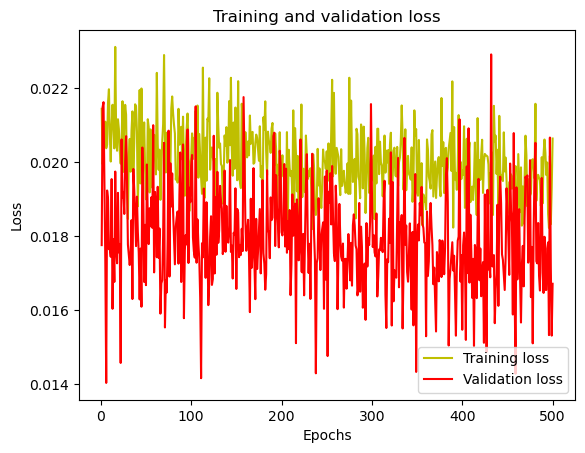

In [19]:
num_epochs = 500
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




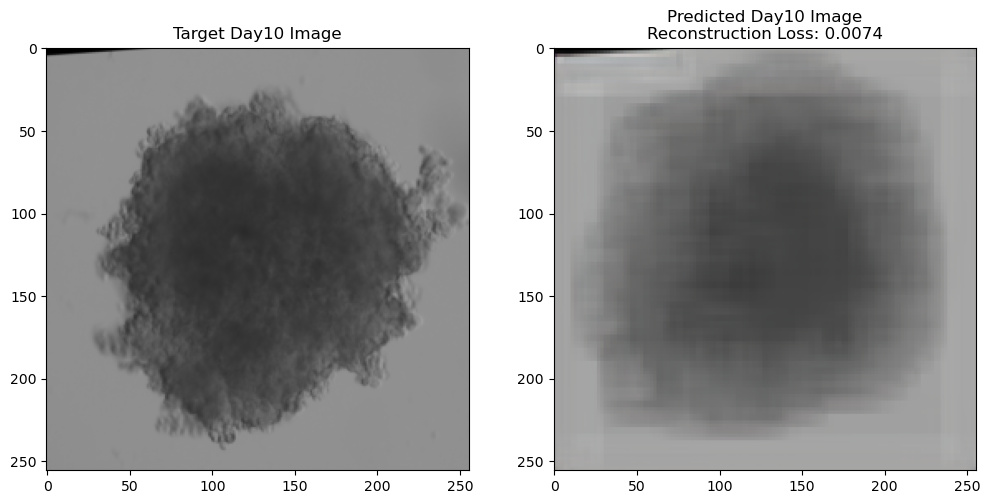

In [21]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
day7_images, day10_targets = data_batch  # Unpack the input (day7) and target (day10) images

modi.eval()
with torch.no_grad():
    # Get the predicted day10 images from the model
    day10_predictions = modi(day7_images)

# Randomly select an image from the batch
image_number = random.randint(0, day10_predictions.shape[0] - 1)

# Calculate the reconstruction loss for the selected image
single_image_loss = criterion(
    day10_predictions[image_number].unsqueeze(0), 
    day10_targets[image_number].unsqueeze(0)
).item()

# Display the target and predicted images
plt.figure(figsize=(12, 6))

# Target day10 image
plt.subplot(121)
plt.title(f'Target Day10 Image')
plt.imshow(np.transpose(day10_targets[image_number].numpy(), (1, 2, 0)))

# Predicted day10 image
plt.subplot(122)
plt.title(f'Predicted Day10 Image\nReconstruction Loss: {single_image_loss:.4f}')
plt.imshow(np.transpose(day10_predictions[image_number].numpy(), (1, 2, 0)))

plt.show()


#check for whether pairing day7 with day 10 is working properly 

In [15]:
import os

class ImagePairingChecker:
    def __init__(self, day7_dir, day10_dir):
        self.day7_files = {os.path.basename(file): os.path.join(day7_dir, file) for file in os.listdir(day7_dir) if file.endswith('.tiff')}
        self.day10_files = {os.path.basename(file): os.path.join(day10_dir, file) for file in os.listdir(day10_dir) if file.endswith('.tiff')}

        # Ensure all day7 files have a corresponding day10 file
        self.common_files = list(self.day7_files.keys())
        assert set(self.common_files) <= set(self.day10_files.keys()), "Mismatch between day7 and day10 filenames."

    def print_paired_paths(self):
        for filename in self.common_files:
            day7_img_path = self.day7_files[filename]
            day10_img_path = self.day10_files[filename]
            print(f"Day7: {day7_img_path} | Day10: {day10_img_path}")
        
        # Print the total number of pairs
        print(f"\nTotal number of paired images: {len(self.common_files)}")


# Example usage
day7_dir = os.path.abspath(r'C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\day7')
day10_dir = os.path.abspath(r'C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\day10')


pairing_checker = ImagePairingChecker(day7_dir, day10_dir)
pairing_checker.print_paired_paths()

Day7: C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\day7\RBTDS1B_D07-T01.tiff | Day10: C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\day10\RBTDS1B_D07-T01.tiff
Day7: C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\day7\RBTDS1B_D08-T01.tiff | Day10: C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\day10\RBTDS1B_D08-T01.tiff
Day7: C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\day7\RBTDS1B_D09-T01.tiff | Day10: C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\day10\RBTDS1B_D09-T01.tiff
Day7: C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\day7\RBTDS1B_D10-T01.tiff | Day10: C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\day10\RBTDS1B_D10-T01.tiff
Day7: C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\day7\RBTDS1B_D11-T01.tiff | Day10: C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\day10\RBTDS1B_D11-T01.tiff
Day7: C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\day7\RBTDS1B_E07